***Domaci 3***

Kreirana je klasa SVM koja kao parametre za inicijalizaciju ima stringove problem i margin. Promjenljiva problem moze biti 'primal' ili 'dual', dok margin moze uzeti vrijednosti 'hard' (nema regularizacije) ili 'soft' (ima regularizacije). Ukoliko je problem dualni koristi se gaussov kernel. Za minimizaciju koristen je cvxopt paket, tj. funkcija cvxopt.solver.qp, pri cemu je form primalnog i dualnog Lagranzijana prilagodjena formi za cvxopt.
Klasa SVM sadrzi metodu za fitovanje, metodu za kreiranje Gaussovog kernela, metodu za predikciju, i metodu za dohvatanje parametara separacione prave w i b. Pored klase SVM, kreirana je i funkcija metrics koja kao ulazne parametre prima tacne vrijednosti labela i prediktovane vrijednosti labela, i na kraju vraca vrijednosti za preciznost, osjetljivost, matricu konfuzije i f1 skor.

In [1]:
# import google drive 
from google.colab import drive
drive.mount('/content/drive')
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive/  sample_data/


In [0]:
import numpy as np
import cvxopt
from math import exp

class SVM:
    
    def __init__(self, problem, margin, c = 1, sigma = 1):
        # problem = {'primal', 'dual'}
        # margin = {'hard', 'soft'}
        # c - cost of soft margin (if it could be said like that)
        # sigma -  standard deviation for gaussian kernel (because gaussian kernel is used for dual problem)
        self.problem = problem
        self.margin = margin
        self.c = c
        self.sigma = sigma
        # Initialize parameters of margin
        self.w = []
        self.b = 0
        
    def gaussian_kernel(self, x, z, sigma):
        # x - dim=1xn
        # z - dim=1xn
        
        result = exp(-((np.linalg.norm(x-z)**2)/(2*sigma**2)))
        return result

        
    def fit(self, X_train, y_train):
        # m - number of train examples
        # n - number of features
        m, n = X_train.shape
        
        if self.problem == 'dual':             
            # Converting dual Lagrangian Ld into CVXOPT format 
            # First compute matrix H, where H[i,j] = y[i]y[j]<x[i,:],x[j,:]>
            H =  np.zeros((m,m))
            for i in range(0, m):
                for j in range(0, m):
                    H[i,j] = y_train[i]*y_train[j]*self.gaussian_kernel(X_train[i,:], X_train[j,:], self.sigma)
                    
            # Create cvxopt matrices
            P = cvxopt.matrix(H)
            q = cvxopt.matrix(-np.ones((m, 1)))
            if self.margin == 'hard':
                G = cvxopt.matrix(-np.eye(m))
                h = cvxopt.matrix(np.zeros(m))
            else: # Margin is soft
                G = cvxopt.matrix(np.vstack((np.eye(m)*(-1),np.eye(m))))
                h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.c)))   
            A = cvxopt.matrix(y_train.T)
            b_cv = cvxopt.matrix(np.zeros(1))

            #Setting solver parameters
            cvxopt.solvers.options['show_progress'] = False
            cvxopt.solvers.options['abstol'] = 1e-10
            cvxopt.solvers.options['reltol'] = 1e-10
            cvxopt.solvers.options['feastol'] = 1e-10 
                
            #Run solver
            sol = cvxopt.solvers.qp(P, q, G, h, A, b_cv)
            alphas = np.array(sol['x'])
                
            #w parameter in vectorized form
            self.w = ((y_train * alphas).T @ X_train).reshape(-1,1)

            #Selecting the set of indices S corresponding to non zero parameters
            S = (alphas > 1e-4).flatten()

            #Computing b
            b = y_train[S] - np.dot(X_train[S], self.w)
                
            # I used first b that I got from first example with alpha>0, for better result use mean value of vector b
            # self.b = np.mean(b)
            self.b = b[0]                
                
        else: # Problem is primal 
            
            if self.margin == 'hard':
                P = np.zeros((n+1,n+1))
                for i in range(0, n):
                    P[i,i] = 1
                q = np.zeros((n+1,1))
                G = np.zeros((m,n+1))
                G[:, 0:n] = y_train*X_train
                G[:, n] = y_train[:,0] 
                G = -G
                h = (-1)*np.ones((m,1))
                
                P = cvxopt.matrix(P)
                q = cvxopt.matrix(q)
                G = cvxopt.matrix(G)
                h = cvxopt.matrix(h)

                #Setting solver parameters
                cvxopt.solvers.options['show_progress'] = False
                cvxopt.solvers.options['abstol'] = 1e-10
                cvxopt.solvers.options['reltol'] = 1e-10
                cvxopt.solvers.options['feastol'] = 1e-10 
                
                #Run solver
                sol = cvxopt.solvers.qp(P, q, G, h)
                z = np.array(sol['x'])

                self.w = z[0:n]
                self.b = z[n]
                
            
            else: # Margin is soft, or there is L1 regularization
                # [w_1, ..., w_n, b, ksi_1, ..., ksi_m] is vector X used in CVXOPT format
                # w - dim=nx1
                # b - scalar
                # ksi - dim=mx1
                P = np.zeros((n+1+m, n+1+m))
                # In original problem we have 0.5*||w||**2 + c*sum(ksi)
                for i in range(0, n):
                    P[i,i] = 1
                q = np.vstack((np.zeros((n+1,1)), self.c*np.ones((m,1))))
                # Constraints are: -gama_kapa - ksi <= -1; -ksi<=0
                G = np.zeros((2*m, n+1+m))
                G[:m, 0:n] = y_train*X_train
                G[:m, n] = y_train[:,0]
                G[:m, n+1:] = np.eye(m)
                G[m:, n+1:] = np.eye(m)
                G = -G
                h = np.zeros((2*m,1))
                h[:m] = -1
                
                P = cvxopt.matrix(P)
                q = cvxopt.matrix(q)
                G = cvxopt.matrix(G)
                h = cvxopt.matrix(h)

                #Setting solver parameters
                cvxopt.solvers.options['show_progress'] = False
                cvxopt.solvers.options['abstol'] = 1e-10
                cvxopt.solvers.options['reltol'] = 1e-10
                cvxopt.solvers.options['feastol'] = 1e-10 
                
                #Run solver
                sol = cvxopt.solvers.qp(P, q, G, h)
                z = np.array(sol['x'])

                self.w = z[0:n]
                self.b = z[n]
    
    def predict(self, x_test):
        
        result = np.sign((self.w.T@x_test.T) + self.b)
            
        return result

In [0]:
#load data
data = np.genfromtxt("drive/My Drive/Colab Notebooks/MU/Domaci_3/data.csv", delimiter=',')
np.random.seed(15)
np.random.shuffle(data)
# y={-1,1}
data[:, -1] = np.where(data[:, -1] == 0, -1, 1)

# train : validate : test = 60 : 20 : 20
# TODO: Try different splitting ratios

ind1 = int(0.6*(np.size(data, axis=0)))
ind2 = int(0.8*(np.size(data, axis=0)))
train = data[0:ind1, :]
validate = data[ind1:ind2, :]
test = data[ind2:, :]

X_train = train[:, 0:-1]
y_train = train[:, -1]
y_train = y_train[:, np.newaxis]
X_validate = validate[:, 0:-1]
y_validate = validate[:, -1]
y_validate = y_validate[:, np.newaxis]
X_test = test[:, 0:-1]
y_test = test[:, -1]
y_test = y_test[:, np.newaxis]

In [0]:
# Function for precision, recall, confusion matrix and f1-score estimation

def metrics(y_true, y_pred):
    
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    # First calculate TP, TN, FP, FN
    for i in range(0, np.size(y_pred, axis=0)): 
        if y_true[i]==y_pred[i]==1:
            TP = TP + 1
        elif (y_pred[i]==1 and y_true[i]!=y_pred[i]):
            FP = FP + 1
        elif y_true[i]==y_pred[i]==-1:
            TN += 1
        else: #if y_pred[i]==-1 and y_true[i]!=y_pred[i]:
            FN += 1
            
    precision_pos = TP/(TP+FP)
    recall_pos = TP/(TP+FN)
    precision_neg = TN/(TN+FN)
    recall_neg = TN/(TN+FP)
    precision = [precision_pos, precision_neg]
    recall = [recall_pos, recall_neg]
    confusion_matrix = np.zeros((2,2))
    confusion_matrix[0][0] = TP
    confusion_matrix[0][1] = FP
    confusion_matrix[1][0] = FN
    confusion_matrix[1][1] = TN
    f1_score_pos = 2/(recall_pos**(-1)+precision_pos**(-1))
    f1_score_neg = 2/(recall_neg**(-1)+precision_neg**(-1))
    f1_score = [f1_score_pos, f1_score_neg]
    accuracy = (np.where(y_true == y_pred, 1, 0).sum())/np.size(y_true, axis=0)
    
    return precision, recall, confusion_matrix, f1_score, accuracy   

 S obzirom da je primjera iz negativne klase za oko 130 vise nego primjera iz pozitivne klase, kao metrika za krosvalidaciju koristen je f1 skor za pozitivnu klasu.

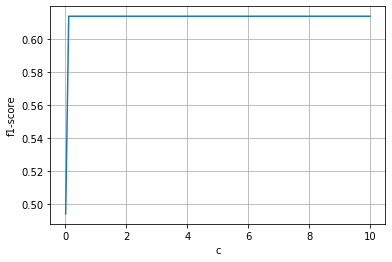

In [7]:
import matplotlib.pyplot as plt
# Using validation set to estimate best value of c for primal problem

# First create object SVM primal
c_list = np.linspace(0.01,10,100)
f = np.zeros(len(c_list))
for i in range(0, len(c_list)):
    # Create object of SVM_primal with c[i]
    SVM_primal = SVM(problem='primal',margin='soft', c=c_list[i])
    # Train object on train data
    SVM_primal.fit(X_train, y_train)
    # Make predictions on validation set
    y_pred_val = np.zeros((np.size(y_validate, axis=0),1))
    for j in range(0, np.size(y_validate, axis=0)):
        y_pred_val[j] = SVM_primal.predict(X_validate[j,:])
    # Calculate f1-score on validation set
    p, r, cm, f1, acc = metrics(y_validate, y_pred_val)
    f[i] = f1[0]

# Plotting accuracy(c)
plt.figure()
plt.plot(c_list, f)
plt.xlabel('c')
plt.ylabel('f1-score')
plt.grid()
plt.show()

In [8]:
# Choose c
c_primal = 3

# Create model
SVM_primal_final = SVM(problem='primal', margin='soft', c=c_primal)
# Train model
SVM_primal_final.fit(X_train, y_train)
# Make predictions on test set
y_pred_test = np.zeros((np.size(y_test,axis=0),1))
for i in range(0, np.size(y_test, axis=0)):
    y_pred_test[i] = SVM_primal_final.predict(X_test[i,:])
    
# Calculate performance metrics
p, r, cm, f1, acc = metrics(y_test, y_pred_test)
print('Precision for positive class:', p[0])
print('Precision for negative class:', p[1])
print('Recall for positive class:', r[0])
print('Recall for negative class:', r[1])
print('Confusion matrix:', cm)
print('F1-score for positive class:', f1[0])
print('F1-score for negative class:', f1[1])
print('Accuracy:', acc)

Precision for positive class: 0.7636363636363637
Precision for negative class: 0.8181818181818182
Recall for positive class: 0.7241379310344828
Recall for negative class: 0.8470588235294118
Confusion matrix: [[42. 13.]
 [16. 72.]]
F1-score for positive class: 0.743362831858407
F1-score for negative class: 0.8323699421965318
Accuracy: 0.7972027972027972


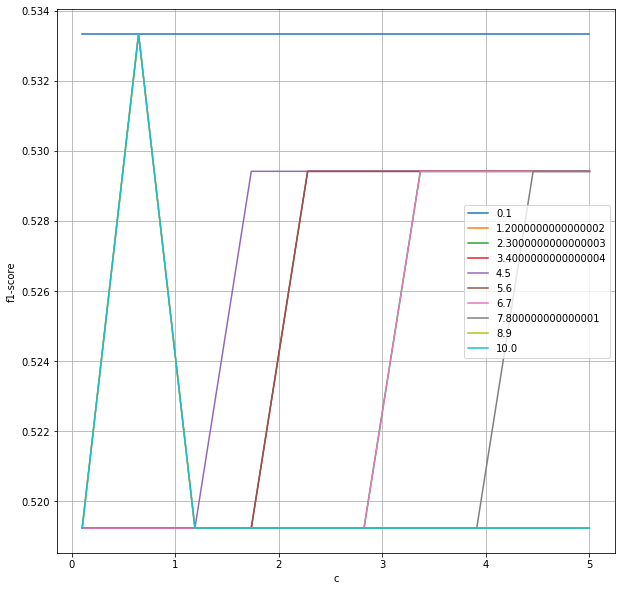

In [15]:
# Using crossvalidation to determine best c and sigma for dual problem

sigma_list = np.linspace(0.1,10,10)
c_list = np.linspace(0.1,5,10)
f = np.zeros((len(sigma_list), len(c_list)))
for i in range(0, len(sigma_list)):
    for j in range(0, len(c_list)):
        # Create object of SVM_dual with sigma_list[i] and c_list[j]
        SVM_dual = SVM(problem='dual', margin='soft', c=c_list[j], sigma=sigma_list[i])
        # Train object on train data
        SVM_dual.fit(X_train, y_train)
        # Make predictions on validation set
        y_pred_val = np.zeros((np.size(y_validate, axis=0),1))
        for k in range(0, np.size(y_validate, axis=0)):
            y_pred_val[k] = SVM_dual.predict(X_validate[k,:])
        # Calculate accuracy 
        p, r, cm, f1, acc = metrics(y_validate, y_pred_val)
        f[i,j] = f1[0]

# Plotting accuracy(c)
plt.figure(figsize=(10,10))
for i in range(0, np.size(f, axis=0)):
    plt.plot(c_list, f[i,:], label=sigma_list[i])
plt.legend(loc='best')
plt.xlabel('c')
plt.ylabel('f1-score')
plt.grid()
plt.show()

In [13]:
# Choose c
c_dual = 3
sigma_dual = 0.1

# Create model
SVM_dual_final = SVM(problem='dual', margin='soft', c=c_dual, sigma=sigma_dual)
# Train model
SVM_dual_final.fit(X_train, y_train)
# Make predictions on test set
y_pred_test = np.zeros((np.size(y_test,axis=0),1))
for i in range(0, np.size(y_test, axis=0)):
    y_pred_test[i] = SVM_dual_final.predict(X_test[i,:])
    
# Calculate performance metrics
p, r, cm, f1, acc = metrics(y_test, y_pred_test)
print('Precision for positive class:', p[0])
print('Precision for negative class:', p[1])
print('Recall for positive class:', r[0])
print('Recall for negative class:', r[1])
print('Confusion matrix:', cm)
print('F1-score for positive class:', f1[0])
print('F1-score for negative class:', f1[1])
print('Accuracy:', acc)

Precision for positive class: 0.5957446808510638
Precision for negative class: 0.6875
Recall for positive class: 0.4827586206896552
Recall for negative class: 0.7764705882352941
Confusion matrix: [[28. 19.]
 [30. 66.]]
F1-score for positive class: 0.5333333333333333
F1-score for negative class: 0.7292817679558011
Accuracy: 0.6573426573426573
